In [1]:
# https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

# Method FFT

In [2]:
import numpy as np

In [3]:
ts = np.loadtxt('FFT.txt')
ts = ts.astype(int)
len(ts)

53

In [4]:
ts

array([4117, 5044, 3595, 1455, 1985, 1909, 1584, 1523, 1607, 1636, 1369,
       1167, 1781, 2476, 1506, 3168, 3021, 2328, 2756,  219, 1434, 3138,
       9760, 1341, 4980, 1394, 1303,  103,  445, 3537, 2102, 3440,   92,
        188, 3619, 3447, 2814, 3707, 3438, 3378, 3157, 3542, 2690, 2712,
       2339, 2238, 2832, 3695, 3460,  269,  520,  602, 1251])

In [5]:
ts_base = ts[:40]
len(ts_base)

40

In [6]:
ts_base

array([4117, 5044, 3595, 1455, 1985, 1909, 1584, 1523, 1607, 1636, 1369,
       1167, 1781, 2476, 1506, 3168, 3021, 2328, 2756,  219, 1434, 3138,
       9760, 1341, 4980, 1394, 1303,  103,  445, 3537, 2102, 3440,   92,
        188, 3619, 3447, 2814, 3707, 3438, 3378])

In [7]:
# Define function for Fourier extrapolation of given timeseries.


def FFT_custom(data, N_predictions, harmonics):  # data is numpy array, N_predictions as integer.
    
    from numpy import fft
    
    n = data.size
    harmonics = harmonics  # Number of harmonics, the more harmonics the more complex signal can be described.
    t = np.arange(0, n)  # Array immitating the sequential time.
    p = np.polyfit(t, data, 1)  # In arguments "1" means fitting the linear trend to historical data: (kx + b)

    # Removing trend from the data. It's like descaling according intercept by time.
    # p[0] is the coefficient determining the angle of the function as it's multiplied with polynomial.
    data_detrended = data - p[0]*t

    data_freq_domain = fft.fft(data_detrended)  # Compute the one-dimensional discrete Fourier Transform.

    f = fft.fftfreq(n)  # Discrete Fourier Transform sample frequencies.

    indexes = list(range(n))
    indexes.sort(key = lambda i: np.absolute(f[i]))

    t = np.arange(0, n + N_predictions)  # Array immitating the sequential time includeing the interval to predict.

    restored_signal = np.zeros(t.size)  # Creating zero base for signal to be restored, allowing then to update values.

    # Iteratively update the values of restored signal.
    for i in indexes[:1 + harmonics*2]:
        amplification = np.absolute(data_freq_domain[i]) / n  # Calculating prediction aplitude.
        phase = np.angle(data_freq_domain[i])  # Calculating prediction phase.
        restored_signal += amplification * np.cos(2 * np.pi * f[i] * t + phase)  # This is FFT itself.
    
    result =  restored_signal + p[0]*t  # Returning the scaling 

    result = [int(i) for i in result]
    
    return result

In [8]:
ts_pred = FFT_custom(ts_base, 13, 10)

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.xlabel("Week number, 2020")
plt.ylabel("Units sold")
plt.plot(ts_pred, marker='o', label='restored_signal')
plt.plot(ts, label = 'original_signal')
plt.legend()

In [10]:
pred = sum(ts_pred[41:])
pred

27224

In [11]:
orig = sum(ts[41:])
orig

26150

In [12]:
accuracy = (orig-pred)/orig
accuracy

-0.041070745697896746

# Method SARIMA

In [13]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html?highlight=sarimax#statsmodels.tsa.statespace.sarimax.SARIMAX

from statsmodels.tsa.statespace.sarimax import SARIMAX


# fit model
model = SARIMAX(ts_base, order=(1, 0, 0), seasonal_order=(2, 1, 1, 1))
model_fit = model.fit(disp=False)

# make prediction
pred_SARIMA = model_fit.predict(0, len(ts))

/Users/konstantinorlovskiy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/konstantinorlovskiy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


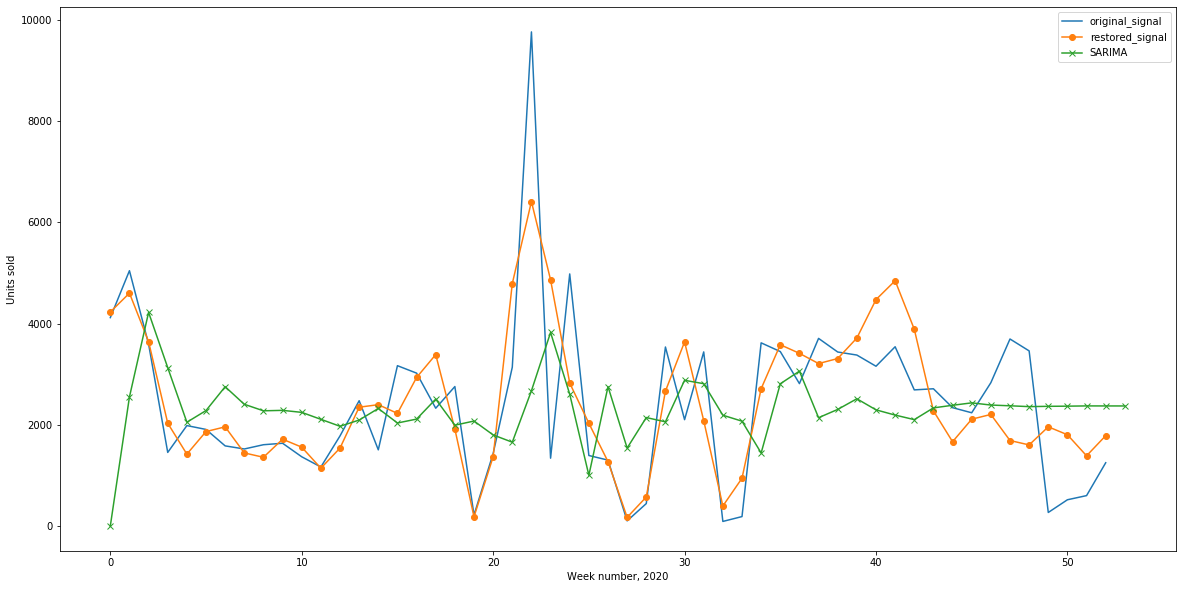

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.xlabel("Week number, 2020")
plt.ylabel("Units sold")
plt.plot(ts, label = 'original_signal')
plt.plot(ts_pred, marker='o', label='restored_signal')
plt.plot(pred_SARIMA, marker='x', label = 'SARIMA')

plt.legend()

over 90% acuracy.